# Gemma

In [1]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("google/gemma-2b-it", dtype="float16")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2b-it into HookedTransformer


## Embeddings

The model has the following embedding features:

In [2]:
for name, param in model.named_parameters():
    if "embed" in name:
        print(name, param.shape)

embed.W_E torch.Size([256000, 2048])
unembed.W_U torch.Size([2048, 256000])
unembed.b_U torch.Size([256000])


### Dataset

Using words in English with Japanese and Spanish translations, I intend to see if there exists information in the embedding that would indicate which language one was speaking in.

In [6]:
from src import datasets
import importlib

importlib.reload(datasets)

# Load Data
eng_jpn_words = datasets.loadMyWordPairs("japanese")
eng_spn_words = datasets.loadMyWordPairs("spanish")

# Convert words to tokens
eng_jpn_tokens = eng_jpn_words.copy()
eng_jpn_tokens["lang1"] = eng_jpn_words["lang1"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])
eng_jpn_tokens["lang2"] = eng_jpn_words["lang2"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])

eng_spn_tokens = eng_spn_words.copy()
eng_spn_tokens["lang1"] = eng_spn_words["lang1"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])
eng_spn_tokens["lang2"] = eng_spn_words["lang2"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])

# Eliminate rows with multiple tokens
def eliminate_multiple_tokens(my_words):
    bad_rows = []
    for i in range(len(my_words)):
        eng_token = my_words.iloc[i]["lang1"]
        sec_token = my_words.iloc[i]["lang2"]

        if eng_token.shape[0] > 1 or sec_token.shape[0] > 1:
            bad_rows.append(i)

    return bad_rows

eng_jpn_tokens = eng_jpn_tokens.drop(eliminate_multiple_tokens(eng_jpn_tokens)).reset_index(drop=True)
eng_spn_tokens = eng_spn_tokens.drop(eliminate_multiple_tokens(eng_spn_tokens)).reset_index(drop=True)

print("Japanese words: ", len(eng_jpn_tokens))
print("Spanish words: ", len(eng_spn_tokens))

Japanese words:  106
Spanish words:  178


### PCA on Difference

Taking the PCA on the difference between the English tokens and the target language tokens, I intend on using PCA to identify 2-axis that best describe the transition between English and another language.

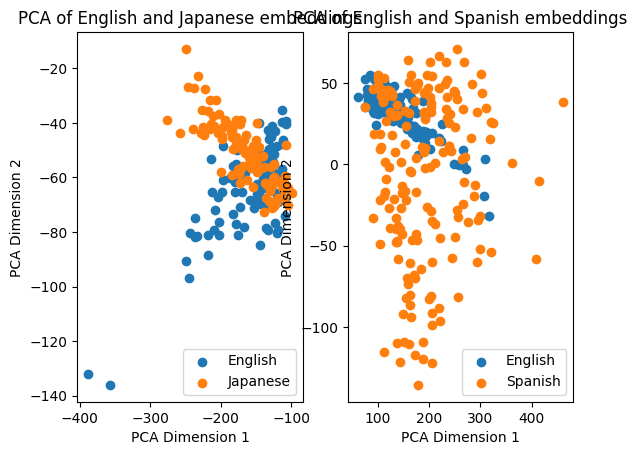

In [7]:
import matplotlib.pyplot as plt
from src import embeddingCompare

importlib.reload(embeddingCompare)

fig = plt.figure()
ax_jpn = fig.add_subplot(121)
ax_spn = fig.add_subplot(122)

ax_jpn.set_title("Japanese")
ax_spn.set_title("Spanish")

eng_jpn_pca = embeddingCompare.plot_embedding_pca(ax_jpn, model, eng_jpn_tokens['lang1'], eng_jpn_tokens['lang2'], 2, "English", "Japanese")
eng_spn_pca = embeddingCompare.plot_embedding_pca(ax_spn, model, eng_spn_tokens['lang1'], eng_spn_tokens['lang2'], 2, "English", "Spanish")
plt.show()

### Compare Direct Axis

Since there appears to be major clustering with the target language compared to the English words, the next step was to identify the axis that were in charge of this behavior.

In [8]:
importlib.reload(embeddingCompare)
jpn_dir, jpn_std, jpn_min, jpn_max = embeddingCompare.compute_average_embedding_direction(model, eng_jpn_tokens['lang1'], eng_jpn_tokens['lang2'])
spn_dir, spn_std, spn_min, spn_max = embeddingCompare.compute_average_embedding_direction(model, eng_spn_tokens['lang1'], eng_spn_tokens['lang2'])

print('\nJapanese Mapping')
embeddingCompare.print_embedding_compare(jpn_dir, jpn_std, jpn_min, jpn_max, 10)
print('\nSpanish Mapping')
embeddingCompare.print_embedding_compare(spn_dir, spn_std, spn_min, spn_max, 10)


Japanese Mapping
Highest mean values:
Index: 16,	Mean: 7.7305,	Std: 4.2148,	Min: -9.6094,	Max: 15.8984
Index: 1703,	Mean: 6.0234,	Std: 3.7559,	Min: -1.9375,	Max: 25.9688
Index: 1385,	Mean: 5.9648,	Std: 3.7422,	Min: -1.5938,	Max: 23.3281
Index: 2044,	Mean: 5.9414,	Std: 2.2773,	Min: 0.3594,	Max: 11.4922
Index: 509,	Mean: 5.8867,	Std: 3.7148,	Min: -4.5078,	Max: 19.8438
Index: 1445,	Mean: 5.5078,	Std: 2.8691,	Min: -2.3906,	Max: 12.6328
Index: 1713,	Mean: 4.2891,	Std: 1.2402,	Min: 0.8828,	Max: 7.3789
Index: 2019,	Mean: 3.4863,	Std: 5.1523,	Min: -12.5625,	Max: 17.2188
Index: 1790,	Mean: 3.2012,	Std: 2.0293,	Min: -1.5039,	Max: 8.3750
Index: 108,	Mean: 3.1367,	Std: 1.9678,	Min: -1.7656,	Max: 7.3320

Spanish Mapping
Highest mean values:
Index: 617,	Mean: 9.6016,	Std: 7.3594,	Min: -9.9062,	Max: 36.5625
Index: 16,	Mean: 9.0938,	Std: 6.5469,	Min: -10.3828,	Max: 27.7500
Index: 1871,	Mean: 9.0625,	Std: 7.2812,	Min: -4.9531,	Max: 40.8125
Index: 1896,	Mean: 8.7031,	Std: 7.9648,	Min: -7.7969,	Max: 35.

Of note, for both Spanish and Japanese, the primary axis that moved the text from English to the target language is axis 1699, with both additionally have corresponding axis of 2034 and 1577 in there top 10. Unfortunately, the uncertainty in these axis are large. Meaning it is difficult to make conclusion statements regarding the results. (With more data, this statement was not true.)

We can use this vector to see if it can accurately convert English words to the target language.

In [11]:
import torch
importlib.reload(embeddingCompare)

print("Japanese Mapping")
print('Input Word\tTarget Word\tProbability\tSimilar Words')
for i in range(10):
    source_word = eng_jpn_words.iloc[i]["lang1"]
    source_token = eng_jpn_tokens.iloc[i]["lang1"]
    target_word = eng_jpn_words.iloc[i]["lang2"]
    target_token = eng_jpn_tokens.iloc[i]["lang2"]

    source_embedding = model.embed(source_token).squeeze(0).detach().numpy()
    source_embedding += jpn_dir
    source_embedding = torch.from_numpy(source_embedding)

    target_prob, word_similarity = embeddingCompare.compare_unembedding_distribution(model, source_embedding, target_token, 5)
    print(f"{source_word}\t\t{target_word}\t\t{target_prob:.4f}\t\t{word_similarity}")


Japanese Mapping
Input Word	Target Word	Probability	Similar Words
go		行く		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
see		見る		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
many		多い		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
home		家		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
this		これ		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
that		それ		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
I		私		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
job		仕事		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
when		いつ		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
do		する		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}


In [12]:
print("Spanish Mapping")
print('Input Word\tTarget Word\tProbability\tSimilar Words')
for i in range(10):
    source_word = eng_spn_words.iloc[i]["lang1"]
    source_token = eng_spn_tokens.iloc[i]["lang1"]
    target_word = eng_spn_words.iloc[i]["lang2"]
    target_token = eng_spn_tokens.iloc[i]["lang2"]

    source_embedding = model.embed(source_token).squeeze(0).detach().numpy()
    source_embedding += spn_dir
    source_embedding = torch.from_numpy(source_embedding)

    target_prob, word_similarity = embeddingCompare.compare_unembedding_distribution(model, source_embedding, target_token, 5)
    print(f"{source_word}\t\t{target_word}\t\t{target_prob:.4f}\t\t{word_similarity}")

Spanish Mapping
Input Word		Target Word		Probability		Similar Words
compete		competir		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
teach		enseñar		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
season		estación		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
plane		avión		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
sure		seguro		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
square		plaza		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
small		pequeño		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
send		enviar		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
come		venir		0.0000		{' increa': 1.0, '<eos>': 0.0, '<unk>': 0.0, '<mask>': 0.0, '<pad>': 0.0}
one hundred		cien		0.0000		{' increa': 1.0, '<eos>': 0.

## Locating Japanese Translations

### Probability of Using English vs Japanese

In [14]:
from src import modelReview

translate_engtext_engword = "Translate this into Japanese.\nEnglish: {}\nJapanese: "
translate_engtext_jpnword = "Translate this into English.\nJapanese: {}\nEnglish: "
translate_jpntext_engword = "英語に翻訳してください。\n日本語:{}\n英語:"
translate_jpntext_jpnword = "日本語に翻訳してください。\n英語:{}\n日本語:"

In [15]:
importlib.reload(modelReview)

prop, nonjapanese_count, sorted_probabilities = modelReview.find_japanese_probability(model, translate_engtext_engword.format("help"))
print(f"Probability of 'help' in Japanese: {prop:.4f}")
print(f"Number of non-Japanese tokens: {nonjapanese_count}")


Probability of 'help' in Japanese: 0.2150
Number of non-Japanese tokens: 0


In [16]:
print("Most likely word: ", model.to_string(sorted_probabilities[0].item()))
print("First Japanese word: ", model.to_string(sorted_probabilities[nonjapanese_count].item()))

Most likely word:  応援
First Japanese word:  応援


In [19]:
importlib.reload(modelReview)

layer_num, logits, cache = modelReview.find_japanese_layer(model, translate_engtext_engword.format("help"))
print(f"Model began to output Japanese at layer {layer_num}")

Model began to output Japanese at layer 0
